# LOADING LIBRARIES

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# LOADING DATASET

In [2]:
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

--2025-02-22 17:01:01--  https://challengedata.ens.fr/media/public/train-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52391647 (50M) [application/zip]
Saving to: ‘train-images.zip’

train-images.zip    100%[===================>]  49.96M  12.3MB/s    in 4.1s    

2025-02-22 17:01:06 (12.3 MB/s) - ‘train-images.zip’ saved [52391647/52391647]

--2025-02-22 17:01:06--  https://challengedata.ens.fr/media/public/test-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12803342 (12M) [application/zip]
Saving to: ‘test-images.zip’

test-images.zip     100%[===================>]  12.21M  8.97MB/s    in 1.4s    

2025-02-22 17:01:08 (8.97 

In [3]:
!unzip train-images.zip
!unzip test-images.zip

Archive:  train-images.zip
   creating: train-images/
  inflating: train-images/348.png    
  inflating: train-images/1804.png   
 extracting: train-images/1810.png   
 extracting: train-images/1186.png   
 extracting: train-images/412.png    
 extracting: train-images/374.png    
  inflating: train-images/1838.png   
 extracting: train-images/360.png    
 extracting: train-images/406.png    
  inflating: train-images/1192.png   
 extracting: train-images/1179.png   
 extracting: train-images/1145.png   
 extracting: train-images/1623.png   
 extracting: train-images/1637.png   
 extracting: train-images/1151.png   
 extracting: train-images/638.png    
  inflating: train-images/176.png    
 extracting: train-images/88.png     
 extracting: train-images/610.png    
 extracting: train-images/1384.png   
 extracting: train-images/1390.png   
 extracting: train-images/604.png    
  inflating: train-images/162.png    
 extracting: train-images/189.png    
 extracting: train-images/837.png 

In [2]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")
    plt.show()

In [3]:
# Read the data and keep first 800 rows
labels = pd.read_csv('y_train.csv', index_col=0).T.iloc[:800]

# Create a new DataFrame with unique values and their counts for each row
result = labels.apply(
    lambda row: pd.Series({
        'num_unique': len(row.unique())
    }),
    axis=1
)

condition = result['num_unique'].apply(lambda x: x > 1)
labels_train = labels[condition]
# Alternative en une ligne
labeled_indices_array = np.where(condition)[0]

Our dataset images shape is torch.Size([759, 1, 256, 256])
Our dataset labels shape is torch.Size([759, 256, 256])


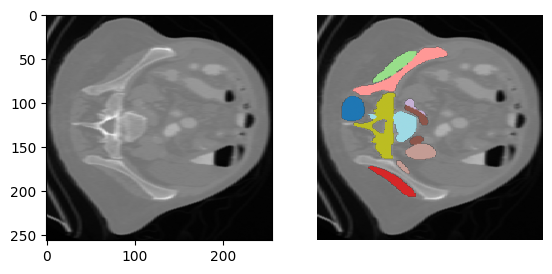

In [4]:
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

## PREPROCESSING
## MIN MAX NORMALIZATION
# data_train = (data_train - np.min(data_train)) / (np.max(data_train) - np.min(data_train))
# data_test = (data_test - np.min(data_test)) / (np.max(data_test) - np.min(data_test))

## STANDARDIZATION
mean, std = data_train.mean(), data_train.std()
data_train = (data_train - mean) / (std + 1e-8)

mean, std = data_test.mean(), data_test.std()
data_test = (data_test - mean) / (std + 1e-8)


data_train_labeled = torch.from_numpy(data_train[labeled_indices_array]).type(torch.float32).reshape((-1, 1, 256,256))
data_test = torch.from_numpy(data_test).type(torch.float32).reshape((-1, 1, 256,256))
labels_train = torch.from_numpy(labels_train.to_numpy()).reshape((-1, 256,256))

print(f"Our dataset images shape is {data_train_labeled.shape}")
print(f"Our dataset labels shape is {labels_train.shape}")
plot_slice_seg(data_train_labeled[5].squeeze(), labels_train[5].squeeze())

In [5]:
## Split for train and test data
X_train, X_valid, y_train, y_valid = train_test_split(data_train_labeled, labels_train, test_size=0.02, random_state=0)
assert len(X_train) == len(y_train)
assert len(X_valid) == len(y_valid)
print(f"Number of training images {len(X_train)}")
print(f"Number of validation images {len(X_valid)}")

Number of training images 743
Number of validation images 16


In [6]:
#construction the data loaders
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=1, shuffle=True)
valid_loader = DataLoader(list(zip(X_valid, y_valid)), batch_size=1, shuffle=False)

dir_checkpoint = Path('./checkpoints/')

# Swin -UNET

In [9]:
! pip install monai timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 910.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [7]:
## Elementary function to test UNET

def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))


def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1): # skip background
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))

In [18]:
def dice_loss(pred, target, smooth=1e-7):

    pred = torch.softmax(pred, dim=1)
    target_onehot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2)
    intersection = (pred * target_onehot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_onehot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [24]:
def train_unet(model, device, train_loader, valid_loader, labels_weights, nb_epochs, save_checkpoint=True) :

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    labels_weights = labels_weights.to(device)

    criterion = nn.CrossEntropyLoss(weight=labels_weights)
    model = model.to(device)

    for epoch in range(nb_epochs) :

        model.train()
        train_loss = 0

        for (image, mask) in train_loader :

            image = image.to(device=device)
            mask = mask.to(device=device)
            optimizer.zero_grad()
            output = model(image)
            loss_ce = criterion(output, mask)
            loss_dice = dice_loss(output, mask)
            loss = 0.5 * loss_dice + 0.5 * loss_ce
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # for name, param in model.named_parameters():
            #   if param.grad is not None and torch.isnan(param.grad).any():
            #       print(f"NaN gradient in {name}")
            #       return "Stooooop"

            optimizer.step()
            train_loss += loss.item()


        with torch.no_grad() :
            model.eval()
            test_loss = 0
            predictions = []
            true_masks = []

            for (image, mask) in valid_loader :
                true_masks.append(mask.cpu().numpy().squeeze())
                image = image.to(device=device)
                mask = mask.to(device=device)

                output = model(image)

                pred = torch.argmax(output, dim=1)
                predictions.append(pred.squeeze().cpu().numpy())

                loss_ce = criterion(output, mask)
                loss_dice = dice_loss(output, mask)
                loss = 0.5 * loss_dice + 0.5 * loss_ce

                test_loss += loss.item()

            predictions = pd.DataFrame(np.array(predictions).reshape((-1, 256*256)))
            valid = pd.DataFrame(np.array(true_masks).reshape((-1, 256*256)))

            score = dice_pandas(valid, predictions)

        print(f"Epoch : {epoch} \t Training Loss : {train_loss / len(train_loader):.3f} \t Test Loss : {test_loss / len(valid_loader):.3f} \t Score: {score:.3f}")

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            #print(f'Checkpoint {epoch} saved!')

In [25]:
import json

# Weights for the cross entropy loss

file_name = "./annotated_labels.json"
with open(file_name, 'r') as file :
    data = json.load(file)

flattened_data = []
for i in data :
    flattened_data += i

labels, labels_count = np.unique(flattened_data, return_counts=True)
labels_weights = labels_count / np.sum(labels_count)

# adding the background
labels_weights = np.insert(labels_weights, 0, 0.0001)
class_weights = torch.from_numpy(labels_weights).type(torch.float32)

In [26]:
from monai.networks.nets import SwinUNETR

NUM_CLASSES = 55
model = SwinUNETR(img_size=(256, 256), in_channels=1,  out_channels=NUM_CLASSES,  feature_size=48, spatial_dims=2).cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")
train_unet(model, device, train_loader, valid_loader, class_weights, nb_epochs=50, save_checkpoint=True)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Device : cuda


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 0 	 Training Loss : 2.002 	 Test Loss : 1.751 	 Score: 0.020


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 1 	 Training Loss : 1.523 	 Test Loss : 1.450 	 Score: 0.049


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 2 	 Training Loss : 1.319 	 Test Loss : 1.299 	 Score: 0.066


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 3 	 Training Loss : 1.199 	 Test Loss : 1.194 	 Score: 0.086


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 4 	 Training Loss : 1.112 	 Test Loss : 1.154 	 Score: 0.109


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 5 	 Training Loss : 1.033 	 Test Loss : 1.119 	 Score: 0.117


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 6 	 Training Loss : 0.984 	 Test Loss : 0.951 	 Score: 0.148


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 7 	 Training Loss : 0.922 	 Test Loss : 0.936 	 Score: 0.144


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 8 	 Training Loss : 0.883 	 Test Loss : 0.930 	 Score: 0.161


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 9 	 Training Loss : 0.840 	 Test Loss : 0.902 	 Score: 0.161


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 10 	 Training Loss : 0.815 	 Test Loss : 0.889 	 Score: 0.172


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 11 	 Training Loss : 0.790 	 Test Loss : 0.846 	 Score: 0.180


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 12 	 Training Loss : 0.762 	 Test Loss : 0.846 	 Score: 0.193


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 13 	 Training Loss : 0.740 	 Test Loss : 0.831 	 Score: 0.190


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 14 	 Training Loss : 0.720 	 Test Loss : 0.814 	 Score: 0.195


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 15 	 Training Loss : 0.702 	 Test Loss : 0.816 	 Score: 0.194


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 16 	 Training Loss : 0.681 	 Test Loss : 0.816 	 Score: 0.200


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 17 	 Training Loss : 0.665 	 Test Loss : 0.836 	 Score: 0.204


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 18 	 Training Loss : 0.656 	 Test Loss : 0.843 	 Score: 0.199


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 19 	 Training Loss : 0.640 	 Test Loss : 0.762 	 Score: 0.215


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 20 	 Training Loss : 0.628 	 Test Loss : 0.760 	 Score: 0.233


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 21 	 Training Loss : 0.615 	 Test Loss : 0.783 	 Score: 0.229


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 22 	 Training Loss : 0.606 	 Test Loss : 0.843 	 Score: 0.210


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 23 	 Training Loss : 0.595 	 Test Loss : 0.801 	 Score: 0.225


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 24 	 Training Loss : 0.587 	 Test Loss : 0.801 	 Score: 0.221


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 25 	 Training Loss : 0.579 	 Test Loss : 0.780 	 Score: 0.230


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 26 	 Training Loss : 0.572 	 Test Loss : 0.855 	 Score: 0.228


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 27 	 Training Loss : 0.562 	 Test Loss : 0.820 	 Score: 0.240


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 28 	 Training Loss : 0.557 	 Test Loss : 0.865 	 Score: 0.230


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 29 	 Training Loss : 0.553 	 Test Loss : 0.788 	 Score: 0.240


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 30 	 Training Loss : 0.548 	 Test Loss : 0.814 	 Score: 0.233


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 31 	 Training Loss : 0.538 	 Test Loss : 0.874 	 Score: 0.238


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 32 	 Training Loss : 0.533 	 Test Loss : 0.851 	 Score: 0.231


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 33 	 Training Loss : 0.535 	 Test Loss : 0.800 	 Score: 0.257


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 34 	 Training Loss : 0.525 	 Test Loss : 0.887 	 Score: 0.245


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 35 	 Training Loss : 0.525 	 Test Loss : 0.790 	 Score: 0.253


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 36 	 Training Loss : 0.522 	 Test Loss : 0.811 	 Score: 0.247


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 37 	 Training Loss : 0.518 	 Test Loss : 0.781 	 Score: 0.258


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 38 	 Training Loss : 0.514 	 Test Loss : 0.909 	 Score: 0.244


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 39 	 Training Loss : 0.511 	 Test Loss : 0.802 	 Score: 0.261


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 40 	 Training Loss : 0.509 	 Test Loss : 0.803 	 Score: 0.266


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 41 	 Training Loss : 0.506 	 Test Loss : 0.873 	 Score: 0.252


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 42 	 Training Loss : 0.503 	 Test Loss : 0.791 	 Score: 0.250


<ipython-input-7-fb3cb528c828>:28: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


Epoch : 43 	 Training Loss : 0.502 	 Test Loss : 0.831 	 Score: 0.260


KeyboardInterrupt: 

In [27]:
test_model = SwinUNETR(img_size=(256, 256), in_channels=1,  out_channels=NUM_CLASSES,  feature_size=48, spatial_dims=2).cuda()
test_model.load_state_dict(torch.load(str(dir_checkpoint / 'checkpoint_epoch40.pth'), weights_only=True))
test_model.eval()

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 48, kernel_size=(2, 2), stride=(2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_features=192,

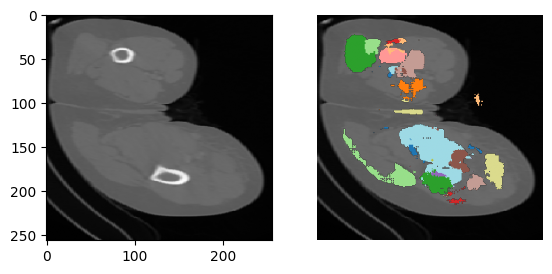

In [28]:
# VISUAL TESTING
image_test = data_test[4]
label_test = test_model(image_test.unsqueeze(0).to(device))
pred_test = torch.argmax(label_test, dim=1)
plot_slice_seg(image_test.squeeze(), pred_test.squeeze().cpu().numpy())